In [1]:
import h3
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from mlxtend.preprocessing import TransactionEncoder

In [2]:
first_file_path = '../00-data/raw/Acidentes_ANSR_2019_desafio_lxdatalab_2020_21.xlsx'
accidents_first_file = pd.read_excel(first_file_path, sheet_name='acidentes')
vehicle_first_file = pd.read_excel(first_file_path, sheet_name='veíc-cond')
passangers_first_file = pd.read_excel(first_file_path, sheet_name='passageiros')
pedestrians_first_file = pd.read_excel(first_file_path, sheet_name='peões')

In [3]:
accidents_first_file = accidents_first_file.set_index('IdAcidente')

In [4]:
vehicle_first_file = vehicle_first_file.set_index('IdAcidente').drop(columns='Datahora')

In [5]:
driver_data = (
    accidents_first_file
    .merge(vehicle_first_file, left_index=True, right_index=True)
    .rename(columns = {'Acessórios Condutores': 'Acessórios'})
    [['Lesões a 30 dias', 'Traçado 1', 'Traçado 2', 'Factores Atmosféricos', 'Luminosidade', 
      'Cond Aderência', 'Categoria Veículos', 'Idade', 'Sexo', 'Acessórios', 'Tipo Natureza']]
)

In [6]:
driver_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4834 entries, 20191648491 to 20201866679
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Lesões a 30 dias       4834 non-null   object 
 1   Traçado 1              4834 non-null   object 
 2   Traçado 2              4834 non-null   object 
 3   Factores Atmosféricos  4834 non-null   object 
 4   Luminosidade           4834 non-null   object 
 5   Cond Aderência         4834 non-null   object 
 6   Categoria Veículos     4834 non-null   object 
 7   Idade                  4630 non-null   float64
 8   Sexo                   4834 non-null   object 
 9   Acessórios             4834 non-null   object 
 10  Tipo Natureza          4834 non-null   object 
dtypes: float64(1), object(10)
memory usage: 453.2+ KB


In [7]:
passanger_data = (
    accidents_first_file
    .merge(vehicle_first_file, left_index=True, right_index=True)
    .rename(columns = {'Id. Veiculo': 'Id. Veículo'})
    .drop(columns = ['Idade', 'Sexo', 'Lesões a 30 dias', 'Acessórios Condutores'])
    .reset_index()
    .merge(passangers_first_file, on=['IdAcidente', 'Id. Veículo'])
    .rename(columns = {'Acessórios Passageiro': 'Acessórios'})
    [['Lesões a 30 dias', 'Traçado 1', 'Traçado 2', 'Factores Atmosféricos', 'Luminosidade', 
      'Cond Aderência', 'Categoria Veículos', 'Idade', 'Sexo', 'Acessórios', 'Tipo Natureza']]
)

In [8]:
model_data = pd.concat([driver_data, passanger_data])

In [9]:
coluna = 'Lesões a 30 dias'

In [10]:
model_data = model_data.replace({'Lesões a 30 dias': {'Ileso': 0, 'Ferido leve': 1, 'Ferido grave': 1, 'Morto':1}})

In [11]:
model_data[coluna].value_counts()

0    2828
1    2637
Name: Lesões a 30 dias, dtype: int64

In [12]:
# model_data = (
#     pd.concat([model_data, pd.get_dummies(model_data[coluna])], axis=1)
#     .drop(columns = [coluna])
# )

In [13]:
# model_data = model_data.replace({'Lesões a 30 dias': {'Morto': 'Ferido grave'}})

In [14]:
coluna = 'Traçado 1'

In [15]:
model_data = model_data.replace({coluna: {'NÃO DEFINIDO': model_data[coluna].mode()}})

In [16]:
model_data[coluna].value_counts()

Recta    4689
Curva     776
Name: Traçado 1, dtype: int64

In [17]:
model_data = (
    pd.concat([model_data, pd.get_dummies(model_data[coluna]).drop(columns = 'Recta')], axis=1)
    .drop(columns = [coluna])
)

In [18]:
coluna = 'Traçado 2'

In [19]:
model_data = model_data.replace({coluna: {'NÃO DEFINIDO': model_data[coluna].mode()}})

In [20]:
model_data[coluna].value_counts()

Em patamar        3584
Com inclinação    1864
Em Lomba            17
Name: Traçado 2, dtype: int64

In [21]:
model_data = (
    pd.concat([model_data, pd.get_dummies(model_data[coluna]).drop(columns = 'Em patamar')], axis=1)
    .drop(columns = [coluna])
)

In [22]:
coluna = 'Factores Atmosféricos'

In [23]:
model_data = model_data.replace({coluna: {'NÃO DEFINIDO': model_data[coluna].mode()}})

In [24]:
model_data[coluna].value_counts()

Bom tempo    4702
Chuva         763
Name: Factores Atmosféricos, dtype: int64

In [25]:
model_data = (
    pd.concat([model_data, pd.get_dummies(model_data[coluna]).drop(columns = 'Bom tempo')], axis=1)
    .drop(columns = [coluna])
)

In [26]:
coluna = 'Luminosidade'

In [27]:
model_data = model_data.replace({coluna: {'NÃO DEFINIDO': model_data[coluna].mode()}})

In [28]:
model_data[coluna].value_counts()

Em pleno dia             3620
Noite, com iluminação    1545
Aurora ou crepúsculo      263
Noite, sem iluminação      28
Sol escandeante             9
Name: Luminosidade, dtype: int64

In [29]:
model_data = (
    pd.concat([model_data, pd.get_dummies(model_data[coluna]).drop(columns = 'Em pleno dia')], axis=1)
    .drop(columns = [coluna])
)

In [30]:
coluna = 'Cond Aderência'

In [31]:
model_data = model_data.replace({coluna: {'NÃO DEFINIDO': 'Outro_piso',
                                          'Com óleo': 'Outro_piso', 
                                          'Com água acumulada na faixa de rodagem': 'Molhado',
                                          'Húmido': 'Molhado',
                                          'Com gravilha ou areia': 'Outro_piso',
                                          'Com lama': 'Outro_piso'}})

In [32]:
model_data[coluna].value_counts()

Seco e limpo    4506
Molhado          887
Outro_piso        72
Name: Cond Aderência, dtype: int64

In [33]:
model_data = (
    pd.concat([model_data, pd.get_dummies(model_data[coluna]).drop(columns = 'Seco e limpo')], axis=1)
    .drop(columns = [coluna])
)

In [34]:
coluna = 'Categoria Veículos'

In [35]:
model_data = model_data.replace({coluna: {'NÃO DEFINIDO': 'Outro', 
                                          'Desconhecido': 'Outro', 
                                          'Velocípede com motor': 'Velocípede', 
                                          'Veículo agrícola': 'Outro',
                                          'Quadriciclo': 'Outro'}})

In [36]:
model_data[coluna].value_counts()

Automóvel ligeiro                3825
Motociclo cilindrada <= 125cc     760
Motociclo cilindrada > 125cc      367
Velocípede                        170
Automóvel pesado                  156
Ciclomotor                        126
Triciclo                           32
Veículo sobre carris               17
Outro                              12
Name: Categoria Veículos, dtype: int64

In [37]:
model_data = (
    pd.concat([model_data, pd.get_dummies(model_data[coluna])
               .drop(columns = 'Outro')], axis=1)
    .drop(columns = [coluna])
)

In [38]:
coluna = 'Sexo'

In [39]:
model_data = model_data.replace({coluna: {'NÃO DEFINIDO': model_data[coluna].mode()}})

In [40]:
model_data[coluna].value_counts()

Masculino    3912
Feminino     1553
Name: Sexo, dtype: int64

In [41]:
model_data = (
    pd.concat([model_data, pd.get_dummies(model_data[coluna]).drop(columns = 'Masculino')], axis=1)
    .drop(columns = [coluna])
)

In [42]:
coluna = 'Idade'

In [43]:
model_data.fillna(value = {coluna: model_data[coluna].mean()}, inplace=True)

In [44]:
coluna = 'Acessórios'

In [45]:
model_data = model_data.replace({coluna: {'NÃO DEFINIDO': 'Outro',
                                          'Isento': 'Outro',
                                          'Cinto de segurança': 'Seguro',
                                          'Capacete': 'Seguro',
                                          'C/ capacete/ cinto segurança': 'Seguro',
                                          'Sem uso de cinto/capacete': 'Inseguro',
                                          'S/ uso capacete/cinto segurança': 'Inseguro',
                                          'C/ sistema retenção de crianças': 'Seguro'}})

In [46]:
model_data[coluna].value_counts()

Seguro      4666
Outro        686
Inseguro     113
Name: Acessórios, dtype: int64

In [47]:
model_data = (
    pd.concat([model_data, pd.get_dummies(model_data[coluna]).drop(columns = 'Seguro')], axis=1)
    .drop(columns = [coluna])
)

In [48]:
coluna = 'Tipo Natureza'

In [49]:
model_data[coluna].value_counts()

Colisão          4047
Atropelamento     711
Despiste          707
Name: Tipo Natureza, dtype: int64

In [50]:
model_data = (
    pd.concat([model_data, pd.get_dummies(model_data[coluna]).drop(columns = 'Colisão')], axis=1)
    .drop(columns = [coluna])
)

In [51]:
X = model_data.drop(columns = ['Lesões a 30 dias'])
y = model_data.copy().pop('Lesões a 30 dias')

In [98]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=y.index)

In [99]:
import statsmodels.api as sm
model = sm.OLS(y, X_scaled)
results_fu = model.fit_regularized(alpha = 5e-3, refit=True)
print(results_fu.summary())

                                 OLS Regression Results                                
Dep. Variable:       Lesões a 30 dias   R-squared (uncentered):                   0.673
Model:                            OLS   Adj. R-squared (uncentered):              0.672
Method:                 Least Squares   F-statistic:                              801.8
Date:                Wed, 05 May 2021   Prob (F-statistic):                        0.00
Time:                        10:40:47   Log-Likelihood:                         -2707.7
No. Observations:                5465   AIC:                                      5443.
Df Residuals:                    5451   BIC:                                      5536.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [89]:
results_fu.summary()

NotImplementedError: 

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [68]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)

In [72]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(clf, X, y, cv=10)
# np.mean(cv_results['test_score'])
cv_results

{'fit_time': array([0.36057162, 0.33910847, 0.33588147, 0.33502388, 0.34668207,
        0.33849192, 0.34102631, 0.3425107 , 0.33277988, 0.33604646]),
 'score_time': array([0.00196218, 0.00295067, 0.00242996, 0.00300217, 0.00197077,
        0.00195932, 0.00300241, 0.00193834, 0.00200558, 0.00199962]),
 'test_score': array([0.80255941, 0.81352834, 0.79341865, 0.81535649, 0.80804388,
        0.77655678, 0.78021978, 0.73992674, 0.78754579, 0.75457875])}

In [74]:
clf.fit(X, y)
pd.DataFrame(clf.feature_importances_, index =X.columns).sort_values(0, ascending=False)

,0
Automóvel ligeiro,0.453787
Atropelamento,0.172891
Automóvel pesado,0.081514
Idade,0.079238
Feminino,0.065167
Despiste,0.042302
Seguro,0.035366
Inseguro,0.030690
Masculino,0.012101
Motociclo cilindrada <= 125cc,0.008663


In [76]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, clf.predict(X))

array([[2470,  358],
       [ 700, 1937]], dtype=int64)

## 9. Grid search

### 9.1. v1

In [70]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [81]:
model_v1 = GradientBoostingClassifier(min_samples_split=10, min_samples_leaf=50, max_depth = 5, max_features = 'sqrt', subsample = 0.8,
                                      random_state = 0)
param_test1 = {'n_estimators':range(100,201,10)}

In [82]:
gsearch1 = GridSearchCV(estimator = model_v1, param_grid = param_test1, scoring='f1', n_jobs=-1, cv=10)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_

{'n_estimators': 200}

In [80]:
gsearch1.best_score_

0.7422532904815541

### 9.2. v2

In [83]:
model_v2 = GradientBoostingClassifier(min_samples_split=10, max_features = 'sqrt', subsample = 0.8, 
                                      n_estimators = 200, random_state = 0)
param_test2 = {'max_depth':range(1,8,1), 'min_samples_split':range(2,30,1)}

In [84]:
gsearch2 = GridSearchCV(estimator = model_v2, param_grid = param_test2, scoring='f1', n_jobs=-1, cv=10)
gsearch2.fit(X_train, y_train)
gsearch2.best_params_

{'max_depth': 3, 'min_samples_split': 10}

In [110]:
gsearch2.best_score_

0.8449222149695388

### 9.3. v3

In [116]:
model_v3 = GradientBoostingClassifier(min_samples_split=12, max_features = 'sqrt', subsample = 0.8, 
                                      n_estimators = 4, max_depth = 2, random_state = 0)
param_test3 = {'min_samples_split':range(2,6,1), 'min_samples_leaf':range(60,85,1)}

In [117]:
gsearch3 = GridSearchCV(estimator = model_v3, param_grid = param_test3, scoring='roc_auc_ovo_weighted', n_jobs=-1, cv=10)
gsearch3.fit(X_train, y_train)
gsearch3.best_params_

{'min_samples_leaf': 71, 'min_samples_split': 2}

In [115]:
gsearch3.best_score_

0.8407887519944879

### 9.4. v4

In [118]:
model_v4 = GradientBoostingClassifier(max_features = 'sqrt', subsample = 0.8,   
                                      n_estimators = 4, max_depth = 4, min_samples_leaf = 71, min_samples_split=2, 
                                      random_state = 0)
param_test4 = {'max_features':range(2,20,1)}

In [119]:
gsearch4 = GridSearchCV(estimator = model_v4, param_grid = param_test4, scoring='roc_auc_ovo_weighted', n_jobs=-1, cv=10)
gsearch4.fit(X_train, y_train)
gsearch4.best_params_

{'max_features': 9}

In [120]:
gsearch4.best_score_

0.860845991532492

### 9.5. v5

In [145]:
model_v5 = GradientBoostingClassifier(n_estimators = 4, max_depth = 4, min_samples_leaf = 71, 
                                      min_samples_split=2, max_features = 9, random_state = 0)
param_test5 = {'subsample':[0.46, 0.47, 0.48]}

In [146]:
gsearch5 = GridSearchCV(estimator = model_v5, param_grid = param_test5, scoring='roc_auc_ovo_weighted', n_jobs=-1, cv=10)
gsearch5.fit(X_train, y_train)
gsearch5.best_params_

{'subsample': 0.48}

In [132]:
gsearch5.best_score_

0.8337568220554106

### 9.6. v6

In [157]:
model_v6 = GradientBoostingClassifier(learning_rate=0.01, n_estimators = 4 * 10, 
                                      max_depth = 4, min_samples_leaf = 71, min_samples_split=2, max_features = 9, 
                                      subsample = 0.48, random_state = 0)

In [158]:
cv_results = cross_validate(model_v6, X_train, y_train, cv=10, scoring='roc_auc_ovo_weighted', n_jobs=-1)

In [160]:
print('Mean roc_auc_ovo_weighted: {}'.format(cv_results['test_score'].mean().round(8)))

Mean roc_auc_ovo_weighted: 0.84044618


In [161]:
model_v6.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, max_features=9,
                           min_samples_leaf=71, n_estimators=40, random_state=0,
                           subsample=0.48)

In [162]:
pd.DataFrame(model_v6.feature_importances_, index =X.columns).sort_values(0, ascending=False)

,0
Motociclo cilindrada > 125cc,0.459438
Automóvel ligeiro,0.228514
Idade,0.101055
Motociclo cilindrada <= 125cc,0.070349
"Noite, com iluminação",0.033136
Em pleno dia,0.028998
Curva,0.014665
Com inclinação,0.013571
Masculino,0.011708
Em patamar,0.009687


In [163]:
confusion_matrix(y_train, model_v6.predict(X_train))

array([[3838,    0],
       [  29,    0]], dtype=int64)

In [164]:
model_data

,Lesões a 30 dias,Idade,Curva,Recta,Com inclinação,Em Lomba,Em patamar,Bom tempo,Chuva,Aurora ou crepúsculo,...,Automóvel ligeiro,Automóvel pesado,Ciclomotor,Motociclo cilindrada <= 125cc,Motociclo cilindrada > 125cc,Triciclo,Velocípede,Veículo sobre carris,Feminino,Masculino
IdAcidente,,,,,,,,,,,,,,,,,,,,,
20191648491,0,58.0,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
20191648498,0,25.0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1
20191648520,0,36.0,0,1,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
20191648520,0,37.0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
20191649633,0,53.0,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201831029,0,44.0,0,1,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,1
20201831029,0,61.0,0,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
20201838659,0,49.0,1,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [64]:
from mlxtend.frequent_patterns import apriori

model_data_v2 = model_data.drop(columns = 'Idade')
results = apriori(model_data_v2, min_support=0.0001, use_colnames=True)

In [65]:
results.assign(Len = results.itemsets.str.len())

,support,itemsets,Len
0,0.006206,(Ferido grave),1
1,0.407944,(Ferido leve),1
2,0.585023,(Ileso),1
3,0.000827,(Morto),1
4,0.139636,(Curva),1
...,...,...,...
20854,0.000414,"(Molhado, Automóvel ligeiro, Noite, sem ilumin...",8
20855,0.000207,"(Morto, Bom tempo, Motociclo cilindrada > 125c...",8
20856,0.000207,"(Morto, Bom tempo, Automóvel ligeiro, Recta, M...",8
20857,0.000207,"(Morto, Bom tempo, Motociclo cilindrada > 125c...",8


In [66]:
from mlxtend.frequent_patterns import association_rules

results = association_rules(results, metric="lift", min_threshold=1)

In [73]:
results.sort_values(by='lift', ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
93742,"(Motociclo cilindrada > 125cc, Recta, Chuva, M...","(Em patamar, Morto)",0.000207,0.000207,0.000207,1.0,4834.0,0.000207,inf
93989,"(Motociclo cilindrada > 125cc, Chuva, Masculin...","(Em patamar, Morto)",0.000207,0.000207,0.000207,1.0,4834.0,0.000207,inf
107736,"(Em patamar, Recta, Morto)","(Motociclo cilindrada > 125cc, Chuva, Masculin...",0.000207,0.000207,0.000207,1.0,4834.0,0.000207,inf
107739,"(Em patamar, Em pleno dia, Morto)","(Motociclo cilindrada > 125cc, Recta, Chuva, M...",0.000207,0.000207,0.000207,1.0,4834.0,0.000207,inf
93759,"(Masculino, Chuva, Motociclo cilindrada > 125c...","(Em patamar, Recta, Morto)",0.000207,0.000207,0.000207,1.0,4834.0,0.000207,inf
107707,"(Motociclo cilindrada > 125cc, Chuva, Masculin...","(Em patamar, Recta, Morto)",0.000207,0.000207,0.000207,1.0,4834.0,0.000207,inf
107674,"(Motociclo cilindrada > 125cc, Recta, Chuva, M...","(Em patamar, Morto)",0.000207,0.000207,0.000207,1.0,4834.0,0.000207,inf
107706,"(Motociclo cilindrada > 125cc, Recta, Chuva, M...","(Em patamar, Em pleno dia, Morto)",0.000207,0.000207,0.000207,1.0,4834.0,0.000207,inf
107719,"(Em patamar, Recta, Em pleno dia, Morto)","(Masculino, Chuva, Motociclo cilindrada > 125c...",0.000207,0.000207,0.000207,1.0,4834.0,0.000207,inf
59429,"(Masculino, Chuva, Motociclo cilindrada > 125c...","(Em patamar, Morto)",0.000207,0.000207,0.000207,1.0,4834.0,0.000207,inf


In [61]:
results[results['consequents'] == {'Ferido grave'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1553,"(Motociclo cilindrada <= 125cc, Com inclinação...",(Ferido grave),0.000207,0.006206,0.000207,1.0,161.133333,0.000206,inf
1704,"(Húmido, Velocípede, Bom tempo)",(Ferido grave),0.000207,0.006206,0.000207,1.0,161.133333,0.000206,inf
1791,"(Húmido, Velocípede, Noite, com iluminação)",(Ferido grave),0.000207,0.006206,0.000207,1.0,161.133333,0.000206,inf
7898,"(Noite, com iluminação, Em patamar, Curva, Vel...",(Ferido grave),0.000207,0.006206,0.000207,1.0,161.133333,0.000206,inf
8164,"(Recta, Com inclinação, Motociclo cilindrada <...",(Ferido grave),0.000207,0.006206,0.000207,1.0,161.133333,0.000206,inf
8460,"(Húmido, Recta, Velocípede, Bom tempo)",(Ferido grave),0.000207,0.006206,0.000207,1.0,161.133333,0.000206,inf
8614,"(Noite, com iluminação, Húmido, Recta, Velocíp...",(Ferido grave),0.000207,0.006206,0.000207,1.0,161.133333,0.000206,inf
8775,"(Com inclinação, Motociclo cilindrada <= 125cc...",(Ferido grave),0.000207,0.006206,0.000207,1.0,161.133333,0.000206,inf
8859,"(Seco e limpo, Com inclinação, Motociclo cilin...",(Ferido grave),0.000207,0.006206,0.000207,1.0,161.133333,0.000206,inf
8875,"(Masculino, Com inclinação, Motociclo cilindra...",(Ferido grave),0.000207,0.006206,0.000207,1.0,161.133333,0.000206,inf


In [60]:
model_data_v2

,Ferido grave,Ferido leve,Ileso,Morto,Curva,Recta,Com inclinação,Em Lomba,Em patamar,Bom tempo,...,Automóvel ligeiro,Automóvel pesado,Ciclomotor,Motociclo cilindrada <= 125cc,Motociclo cilindrada > 125cc,Triciclo,Velocípede,Veículo sobre carris,Feminino,Masculino
IdAcidente,,,,,,,,,,,,,,,,,,,,,
20191648491,0,0,1,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
20191648498,0,1,0,0,0,1,0,0,1,1,...,0,0,0,1,0,0,0,0,0,1
20191648520,0,0,1,0,0,1,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
20191648520,0,1,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
20191649633,0,0,1,0,0,1,0,0,1,1,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201831029,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
20201831029,0,1,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
20201838659,0,0,1,0,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [75]:
data

,Lesões a 30 dias,Idade,Curva,Recta,Com inclinação,Em Lomba,Em patamar,Bom tempo,Chuva,Aurora ou crepúsculo,...,Veículo sobre carris,Feminino,Masculino,C/ capacete/ cinto segurança,C/ sistema retenção de crianças,Capacete,Cinto de segurança,Isento,S/ uso capacete/cinto segurança,Sem uso de cinto/capacete
0,Ferido grave,0.832305,1.297307,0.958360,1.080162,0.000000,0.975298,1.081089,0.565462,1.640484,...,0.000000,0.463026,1.279914,1.127967,0.000000,3.219756,0.330394,1.809004,0.000000,2.114938
1,Ferido leve,0.918963,1.127238,0.977689,0.996090,0.989521,0.999971,0.982720,1.096838,1.023383,...,1.236901,1.196919,0.972542,2.086240,2.102732,1.928158,0.549319,0.938956,2.102732,1.082288
2,Ileso,1.076728,0.879071,1.021064,1.002516,1.023068,1.000359,1.014791,0.916843,0.969904,...,0.795719,0.826242,1.021474,0.000000,0.000000,0.117173,1.423184,1.045231,0.000000,0.909393


In [48]:
colision = model_data.loc[model_data['Tipo Natureza'] == 'Colisão'].drop(columns = ['Tipo Natureza'])

In [48]:
data = model_data.groupby('Lesões a 30 dias').mean().div(model_data.mean()).reset_index()

In [49]:
data_v2 = data.melt('Lesões a 30 dias')

In [85]:
data_v2.sort_values(by='value', ascending=False).query('variable == "Chuva"')
# .query('`Lesões a 30 dias` == "Ileso"')

,Lesões a 30 dias,variable,value
22,Ferido leve,Chuva,1.096838
23,Ileso,Chuva,0.916843
21,Ferido grave,Chuva,0.565462


In [96]:
model_data.query('`Cond Aderência` == "Seco e limpo"')['Lesões a 30 dias'].value_counts()

Ileso           2377
Ferido leve     2094
Ferido grave      28
Morto              7
Name: Lesões a 30 dias, dtype: int64

In [89]:
model_data

,Lesões a 30 dias,Traçado 1,Traçado 2,Factores Atmosféricos,Luminosidade,Cond Aderência,Categoria Veículos,Idade,Sexo,Acessórios,Tipo Natureza
20191648491,Ileso,Recta,Em patamar,NÃO DEFINIDO,Em pleno dia,Seco e limpo,Automóvel ligeiro,58.0,Masculino,Cinto de segurança,Atropelamento
20191648498,Ferido leve,Recta,Em patamar,Bom tempo,Em pleno dia,Seco e limpo,Motociclo cilindrada <= 125cc,25.0,Masculino,Capacete,Atropelamento
20191648520,Ileso,Recta,Com inclinação,Bom tempo,Em pleno dia,Seco e limpo,Automóvel ligeiro,36.0,Masculino,Cinto de segurança,Colisão
20191648520,Ferido leve,Recta,Com inclinação,Bom tempo,Em pleno dia,Seco e limpo,Velocípede com motor,37.0,Masculino,Isento,Colisão
20191649633,Ileso,Recta,Em patamar,Bom tempo,Em pleno dia,Seco e limpo,Automóvel ligeiro,53.0,Masculino,Cinto de segurança,Atropelamento
...,...,...,...,...,...,...,...,...,...,...,...
626,Ferido leve,Recta,Em patamar,Chuva,Em pleno dia,Molhado,Automóvel ligeiro,51.0,Feminino,C/ capacete/ cinto segurança,Colisão
627,Ferido leve,Recta,Em patamar,Bom tempo,Em pleno dia,Húmido,Automóvel ligeiro,22.0,Feminino,C/ capacete/ cinto segurança,Colisão
628,Ferido leve,Recta,Em patamar,Chuva,"Noite, com iluminação",Com água acumulada na faixa de rodagem,Automóvel ligeiro,26.0,Feminino,C/ capacete/ cinto segurança,Colisão
629,Ferido leve,Recta,Em patamar,Bom tempo,Em pleno dia,Seco e limpo,Automóvel ligeiro,73.0,Feminino,C/ capacete/ cinto segurança,Colisão


<AxesSubplot:xlabel='value', ylabel='variable'>

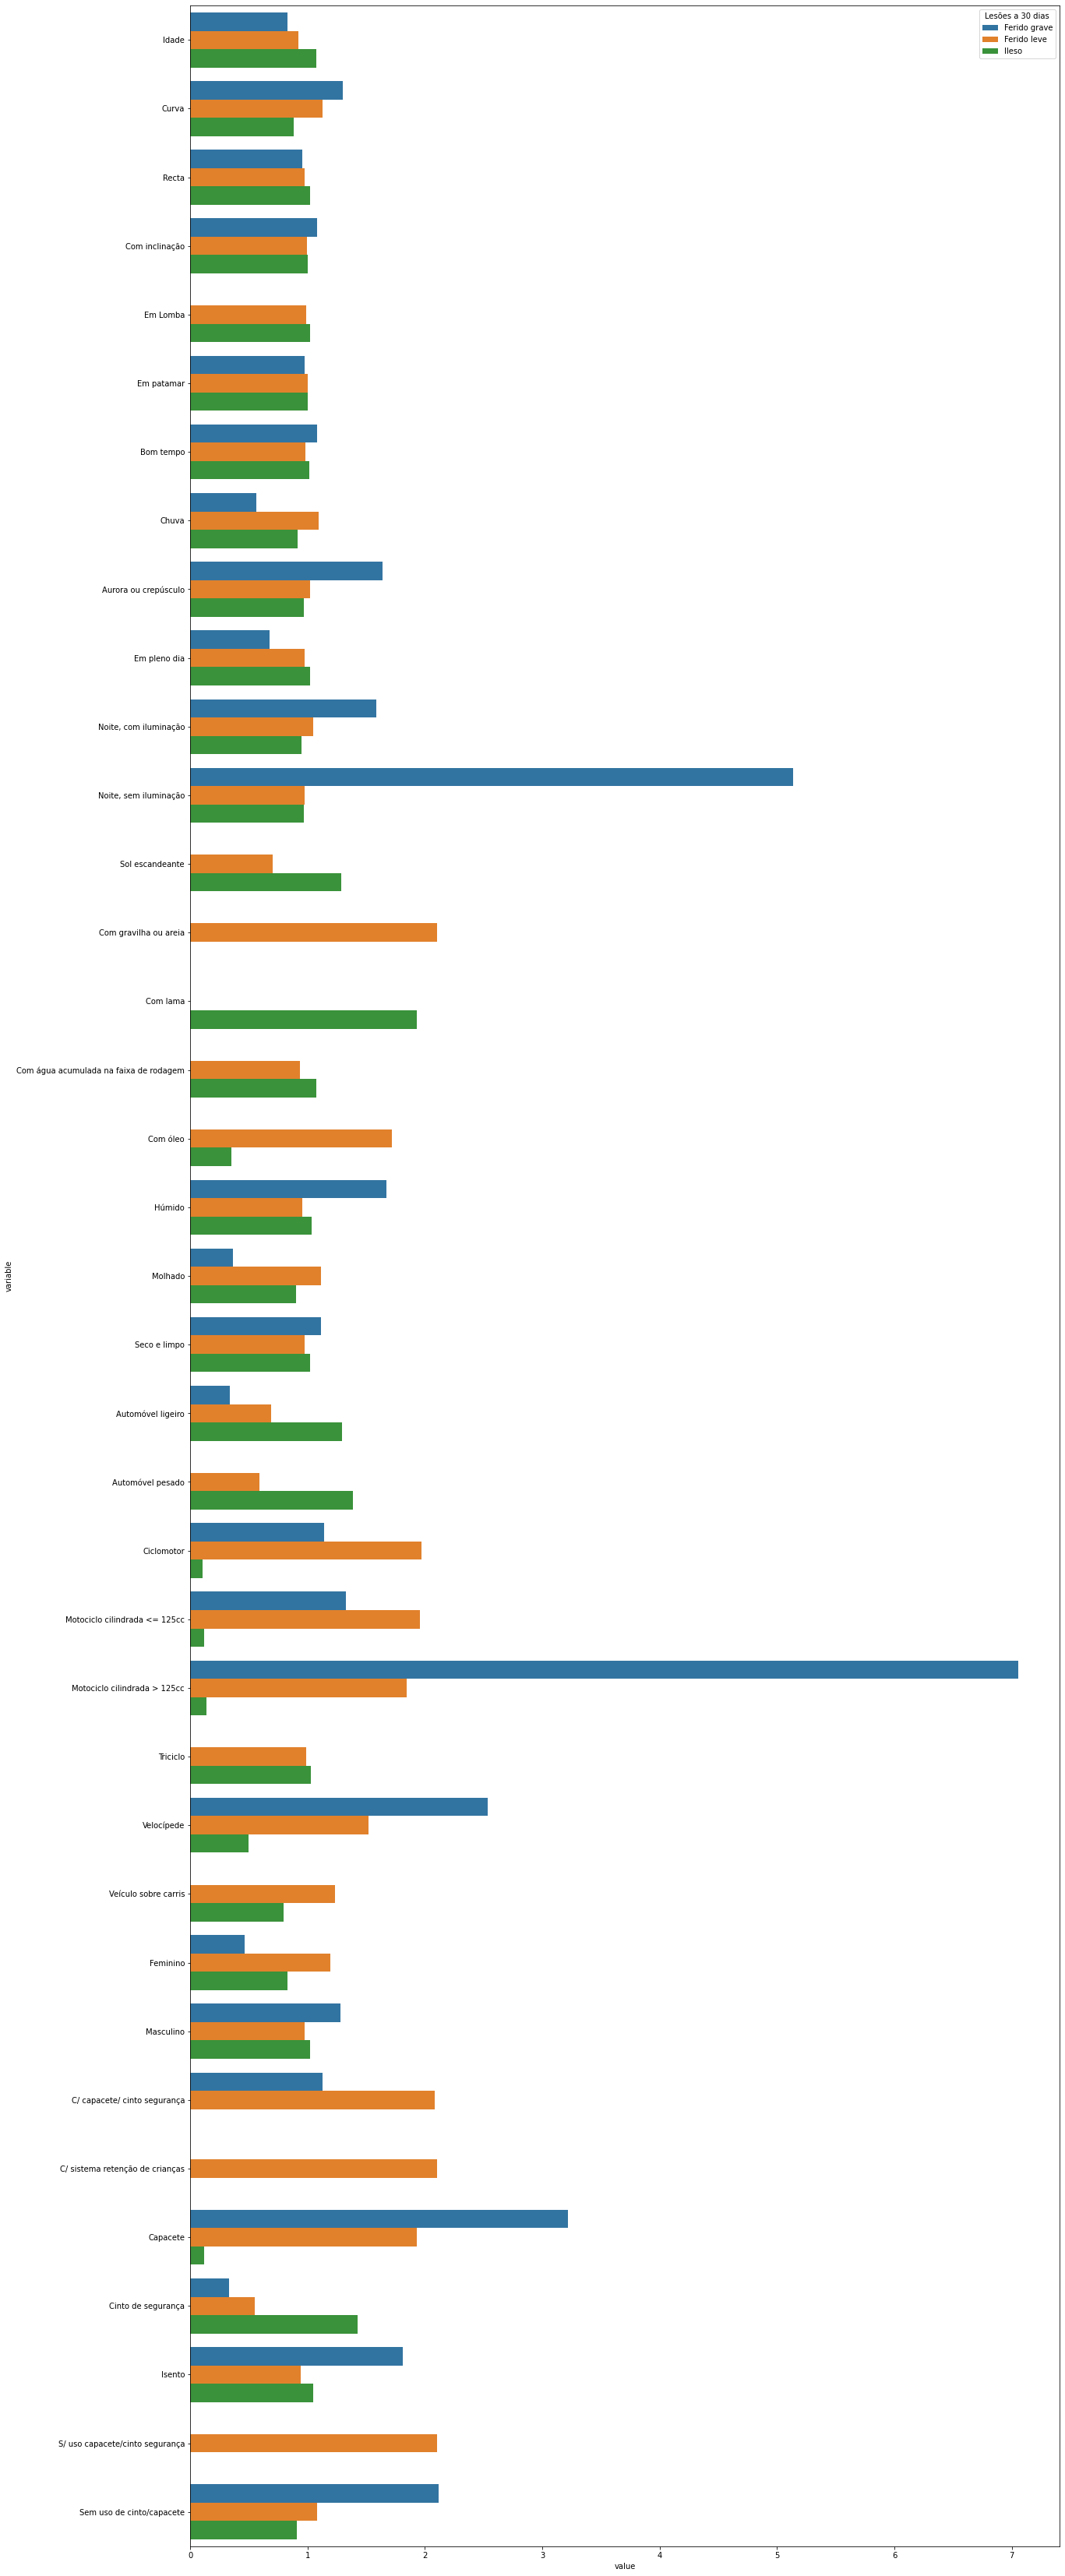

In [81]:
plt.figure(figsize = (20, 60))
sns.barplot(data = data_v2, 
            y = 'variable', 
            x = 'value',
            hue = 'Lesões a 30 dias')

Set Id as index

In [4]:
accidents_first_file = accidents_first_file.set_index('IdAcidente')

Remover nan values

In [5]:
accidents_first_file.isna().sum()

Datahora                       0
Dia da Semana                  0
Sentidos                       0
Latitude GPS                 945
Longitude GPS                945
Via Trânsito                   0
Localizações                   0
Freguesia                      0
Pov. Proxima                1322
Tipo Natureza                  0
Natureza                       0
Traçado 1                      0
Traçado 2                      0
Traçado 3                      0
Traçado 4                      0
Estado Conservação             0
Características Tecnicas       0
Reg Circulação                 0
Marca Via                      0
Obstáculos                     0
Sinais                         0
Sinais Luminosos               0
Tipo Piso                      0
Intersecção Vias               0
Factores Atmosféricos          0
Luminosidade                   0
Cond Aderência                 0
VM                             0
FG                             0
FL                             0
Tipos Vias

In [6]:
clean_accidents_first_file = accidents_first_file.dropna(axis=1)

Evaluate data

In [7]:
clean_accidents_first_file['Sentidos'].value_counts()

NÃO DEFINIDO                               1852
No sentido crescente da quilometragem       477
No sentido decrescente da quilometragem     439
Name: Sentidos, dtype: int64

In [8]:
clean_accidents_first_file = clean_accidents_first_file.replace({'NÃO DEFINIDO': '-'})

In [9]:
clean_accidents_first_file['Via Trânsito'].value_counts()

Direita     2025
Esquerda     492
Central      251
Name: Via Trânsito, dtype: int64

In [10]:
clean_accidents_first_file['Localizações'].value_counts()

Dentro das localidades    2596
Fora das localidades       172
Name: Localizações, dtype: int64

In [11]:
clean_accidents_first_file['Freguesia'].value_counts()

Avenidas Novas             244
Alvalade                   227
Lumiar                     203
São Domingos de Benfica    178
Santa Maria dos Olivais    170
Alcântara                  162
Arroios                    138
Campolide                  126
Estrela                    125
Marvila                    113
Belém                      111
Benfica                    107
Parque das Nações          103
Santo António              102
Santa Maria Maior           99
Areeiro                     85
Campo de Ourique            84
Misericórdia                83
Ajuda                       73
Carnide                     72
Penha de França             66
Santa Clara                 42
São Vicente                 31
Beato                       24
Name: Freguesia, dtype: int64

In [12]:
clean_accidents_first_file['Tipo Natureza'].value_counts()

Colisão          1573
Atropelamento     674
Despiste          521
Name: Tipo Natureza, dtype: int64

In [13]:
clean_accidents_first_file['Natureza'].value_counts()

Atropelamento de peões                                          640
Colisão lateral com outro veículo em movimento                  560
Colisão traseira com outro veículo em movimento                 363
Colisão com outras situações                                    355
Despiste sem dispositivo de retenção                            329
Despiste com dispositivo de retenção                            109
Colisão choque em cadeia                                         97
Colisão com veiculo ou obstáculo na faixa de rodagem             74
Colisão frontal                                                  72
Colisão com fuga                                                 52
Despiste com colisão com veículo imobil. ou obstáculo            48
Atropelamento com fuga                                           33
Despiste com capotamento                                         20
Despiste simples                                                 11
Despiste com fuga                               

In [14]:
clean_accidents_first_file['Traçado 1'].value_counts()

Recta    2327
Curva     422
-          19
Name: Traçado 1, dtype: int64

In [15]:
clean_accidents_first_file['Traçado 2'].value_counts()

Em patamar        1777
Com inclinação     958
-                   24
Em Lomba             9
Name: Traçado 2, dtype: int64

In [16]:
clean_accidents_first_file['Traçado 3'].value_counts()

Berma pavimentada            1702
Sem berma ou impraticável     996
Berma não pavimentada          36
-                              34
Name: Traçado 3, dtype: int64

In [17]:
clean_accidents_first_file['Traçado 4'].value_counts()

Em plena via                   2631
No passeio                       41
-                                30
Em parque de estacionamento      26
Em via ou pista reservada        25
Na berma                         15
Name: Traçado 4, dtype: int64

In [18]:
clean_accidents_first_file['Estado Conservação'].value_counts()

Em estado regular    1684
Em bom estado        1011
Em mau estado          45
-                      28
Name: Estado Conservação, dtype: int64

In [19]:
clean_accidents_first_file['Características Tecnicas'].value_counts()

Estrada sem separador    1552
Outra via                1115
Auto-estrada              101
Name: Características Tecnicas, dtype: int64

In [20]:
clean_accidents_first_file['Reg Circulação'].value_counts()

Sentido único    1622
Dois sentidos    1142
Reversível          4
Name: Reg Circulação, dtype: int64

In [21]:
clean_accidents_first_file['Marca Via'].value_counts()

Com marcas - separadoras de sentido e de vias de trânsito    1785
Sem marcas rodoviárias ou pouco visíveis                      705
Com marcas - separadoras de sentido de trânsito               255
-                                                              23
Name: Marca Via, dtype: int64

In [22]:
clean_accidents_first_file['Obstáculos'].value_counts()

Inexistentes                    2677
-                                 40
Correctamente sinalizados         36
Não sinalizados                    9
Insuficentemente sinalizados       6
Name: Obstáculos, dtype: int64

In [23]:
clean_accidents_first_file['Sinais'].value_counts()

Outros                        1815
-                              531
Passagem de peões              300
Cedência de passagem           100
Stop                            20
Proibição de ultrapassagem       2
Name: Sinais, dtype: int64

In [24]:
clean_accidents_first_file['Tipo Piso'].value_counts()

Betuminoso          2510
Calçada              202
Betão de cimento      30
-                     22
Terra batida           4
Name: Tipo Piso, dtype: int64

In [25]:
clean_accidents_first_file['Intersecção Vias'].value_counts()

Fora da intersecção             1688
Em entroncamento                 452
Em cruzamento                    387
-                                104
Em rotunda                        57
Em via de aceleração              51
Em ramo de ligação - entrada      18
Em via de desaceleração           11
Name: Intersecção Vias, dtype: int64

In [26]:
clean_accidents_first_file['Factores Atmosféricos'].value_counts()

Bom tempo    2323
Chuva         418
-              27
Name: Factores Atmosféricos, dtype: int64

In [27]:
clean_accidents_first_file['Luminosidade'].value_counts()

Em pleno dia             1830
Noite, com iluminação     778
Aurora ou crepúsculo      128
Noite, sem iluminação      16
-                          10
Sol escandeante             6
Name: Luminosidade, dtype: int64

In [28]:
clean_accidents_first_file['Cond Aderência'].value_counts()

Seco e limpo                              2246
Molhado                                    427
Húmido                                      44
-                                           34
Com óleo                                     9
Com água acumulada na faixa de rodagem       4
Com gravilha ou areia                        3
Com lama                                     1
Name: Cond Aderência, dtype: int64

In [29]:
clean_accidents_first_file['Tipos Vias'].value_counts()

Arruamento                      2515
IP- Itinerário Principal         103
A  - Auto-Estrada                101
IC - Itinerário Complementar      36
Outra Via                         10
PNT - Ponte                        3
Name: Tipos Vias, dtype: int64

In [30]:
clean_accidents_first_file['Via'].value_counts()

0             2525
IP7            103
A5              56
A2              44
IC17            22
IC19            14
PNT25ABRIL       3
A1               1
Name: Via, dtype: int64

In [31]:
clean_accidents_first_file.drop(columns = ['Via'], inplace=True)

In [32]:
clean_accidents_first_file['Localização 2'].value_counts()

Sem GPS - não estimado    944
Localização GPS           924
Sem GPS - estimado        900
Name: Localização 2, dtype: int64

In [33]:
clean_accidents_first_file.drop(columns = ['Localização 2'], inplace=True)

In [34]:
clean_accidents_first_file.drop(columns = ['VM', 'FG', 'FL', 'Datahora', 'Dia da Semana'], inplace=True)

In [35]:
clean_accidents_first_file.columns

Index(['Sentidos', 'Via Trânsito', 'Localizações', 'Freguesia',
       'Tipo Natureza', 'Natureza', 'Traçado 1', 'Traçado 2', 'Traçado 3',
       'Traçado 4', 'Estado Conservação', 'Características Tecnicas',
       'Reg Circulação', 'Marca Via', 'Obstáculos', 'Sinais',
       'Sinais Luminosos', 'Tipo Piso', 'Intersecção Vias',
       'Factores Atmosféricos', 'Luminosidade', 'Cond Aderência',
       'Tipos Vias'],
      dtype='object')

In [ ]:
clean_accidents_first_file

In [36]:
clean_accidents_first_file

,Sentidos,Via Trânsito,Localizações,Freguesia,Tipo Natureza,Natureza,Traçado 1,Traçado 2,Traçado 3,Traçado 4,...,Marca Via,Obstáculos,Sinais,Sinais Luminosos,Tipo Piso,Intersecção Vias,Factores Atmosféricos,Luminosidade,Cond Aderência,Tipos Vias
IdAcidente,,,,,,,,,,,,,,,,,,,,,
20191648491,-,Direita,Dentro das localidades,Lumiar,Atropelamento,Atropelamento de peões,Recta,Em patamar,Sem berma ou impraticável,Em parque de estacionamento,...,-,Inexistentes,-,-,Betão de cimento,-,-,Em pleno dia,Seco e limpo,Arruamento
20191648498,-,Esquerda,Dentro das localidades,Campo de Ourique,Atropelamento,Atropelamento de peões,Recta,Em patamar,Sem berma ou impraticável,Em plena via,...,Com marcas - separadoras de sentido e de vias ...,Inexistentes,Outros,A funcionar normalmente,Betuminoso,Fora da intersecção,Bom tempo,Em pleno dia,Seco e limpo,Arruamento
20191648520,-,Central,Dentro das localidades,Avenidas Novas,Colisão,Colisão lateral com outro veículo em movimento,Recta,Com inclinação,Sem berma ou impraticável,Em plena via,...,Com marcas - separadoras de sentido e de vias ...,Inexistentes,Passagem de peões,A funcionar normalmente,Betuminoso,Em entroncamento,Bom tempo,Em pleno dia,Seco e limpo,Arruamento
20191649633,-,Direita,Dentro das localidades,Santa Clara,Atropelamento,Atropelamento de peões,Recta,Em patamar,Sem berma ou impraticável,Em plena via,...,Sem marcas rodoviárias ou pouco visíveis,Inexistentes,Outros,Desligada,Betuminoso,Fora da intersecção,Bom tempo,Em pleno dia,Seco e limpo,Arruamento
20191649654,-,Direita,Dentro das localidades,Santo António,Colisão,Colisão traseira com outro veículo em movimento,Recta,Com inclinação,Sem berma ou impraticável,Em plena via,...,Com marcas - separadoras de sentido e de vias ...,Inexistentes,-,A funcionar normalmente,Betuminoso,Em entroncamento,Bom tempo,"Noite, com iluminação",Seco e limpo,Arruamento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201827869,-,Direita,Dentro das localidades,São Domingos de Benfica,Atropelamento,Atropelamento de peões,Recta,Em patamar,Berma pavimentada,Em plena via,...,Com marcas - separadoras de sentido e de vias ...,Inexistentes,Passagem de peões,Inexistentes,Betuminoso,-,Chuva,"Noite, com iluminação",Molhado,Arruamento
20201828362,No sentido crescente da quilometragem,Central,Fora das localidades,Alcântara,Colisão,Colisão com fuga,Curva,Com inclinação,Berma pavimentada,Em plena via,...,Com marcas - separadoras de sentido e de vias ...,Inexistentes,-,Inexistentes,Betuminoso,Fora da intersecção,Bom tempo,"Noite, com iluminação",Seco e limpo,A - Auto-Estrada
20201831029,-,Direita,Dentro das localidades,Parque das Nações,Colisão,Colisão lateral com outro veículo em movimento,Recta,Em patamar,Sem berma ou impraticável,Em plena via,...,Sem marcas rodoviárias ou pouco visíveis,Inexistentes,Outros,Inexistentes,Betuminoso,Fora da intersecção,Chuva,Em pleno dia,Húmido,Arruamento
